In [1]:
#!pip install kaggle
import os
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csc_matrix
import zipfile

In [2]:
prefix = '../data/'
file_names = ['clears.csv','course-meta.csv','courses.csv','likes.csv','players.csv','plays.csv','records.csv']

clears = pd.read_csv(prefix+"clears.csv", delimiter = "\t")
course_meta = pd.read_csv(prefix+"course-meta.csv", delimiter = "\t")
courses = pd.read_csv(prefix+"courses.csv", delimiter = "\t")
likes = pd.read_csv(prefix+"likes.csv", delimiter = "\t")
players = pd.read_csv(prefix+"players.csv", delimiter = "\t")
plays = pd.read_csv(prefix+"plays.csv", delimiter = "\t")
records = pd.read_csv(prefix+"records.csv", delimiter = "\t")

In [3]:
def cleanse_course_meta(course_meta):
    """Keeps just the last entry of course_meta catches per course id"""
    course_meta['catch'] = pd.to_datetime(course_meta['catch'])
    course_meta = course_meta.sort_values(by=['id','catch'])
    course_meta_cleansed = course_meta.groupby(by='id').last().reset_index()
    return course_meta_cleansed

course_meta = cleanse_course_meta(course_meta)

# Datenvalidierung der Datenquelle

## Eignung der Datenquelle

Die Daten bezogen wir von https://www.kaggle.com/leomauro/smmnet. Diese beinhaltet folgende Daten:

<img src="./images/erd.png" width=700>

`players` representiert ein Spieler, welcher ein Kurs `courses` erstellen und spielen kann.<br>
`courses` ist ein erstellter Kurs/Level, welche von einem Spieler `players` erstellt wurde.<br>
`course-meta` beinhaltet die Metadaten eines `courses`. *firstClear* ist derjenige Spieler, welcher als erstes das Level geschafft hat.<br>
`records` hält die Zeitrekorde eines `courses` mit dem entsprechenden Spieler fest. Es sind lediglich die aktuellsten Rekorde enthalten.<br>
`plays` zeigt, wann ein Spieler den entsprechenden Kurs angefangen hat.<br>
`clears` zeigt die erfolgreich abgeschlossenen Levels eines Spielers.<br>
`likes` zeigt, welche Spieler welches Level geliked haben.<br><br>

Die Daten wurden von SMM Bookmark https://supermariomakerbookmark.nintendo.net/ mittels der https://github.com/leomaurodesenv/smm-data-mining API abgerufen. Die SMM Bookmark Webseite ist seit dem 31. März 2021 offline. Unsere Daten von Kaggle beiziehen sich auf Level und Spieler, deren Daten zwischen dem 16.11.2017 und 10.04.2018 gesammelt wurden.<br><br>

Nun schauen wir uns ein paar Beispiele der wichtigsten Tables an, um die Eignung zu validieren:<br><br>

**Players**

In [4]:
players.head()

,id,image,flag,name
0,NolramImpro,http://mii-images.cdn.nintendo.net/3nhht3y6sjm...,BR,Nolram
1,SGK2017,http://mii-images.cdn.nintendo.net/4bxo1rny12r...,JP,しげ
2,preamstrikbiz0,http://mii-images.cdn.nintendo.net/2i0nphr806h...,US,primo
3,gotatari,http://mii-images.cdn.nintendo.net/2dvhs41zz7y...,JP,たくと
4,skrufpanda,http://mii-images.cdn.nintendo.net/2n2gr4n7oxg...,NO,pinkachuz


**Levels**

In [5]:
courses.head()

,id,difficulty,gameStyle,maker,title,thumbnail,image,creation
0,079D-0000-0351-17E2,expert,marioBros3,NolramImpro,Apocalipse 14:12,https://dypqnhofrd2x2.cloudfront.net/079D-0000...,https://dypqnhofrd2x2.cloudfront.net/079D-0000...,2017-08-11 00:00:00
1,07CD-0000-030D-EA60,expert,marioBrosU,igorsssa,Dangerous Ship Fantasy,https://dypqnhofrd2x2.cloudfront.net/07CD-0000...,https://dypqnhofrd2x2.cloudfront.net/07CD-0000...,2017-03-11 00:00:00
2,07F7-0000-030F-A51B,superExpert,marioWorld,Wiggle133,Pow-Ing (Speedrun) (^o^),https://dypqnhofrd2x2.cloudfront.net/07F7-0000...,https://dypqnhofrd2x2.cloudfront.net/07F7-0000...,2017-03-14 00:00:00
3,080E-0000-0307-A394,expert,marioBros,vitorotavio,desafios radcore,https://dypqnhofrd2x2.cloudfront.net/080E-0000...,https://dypqnhofrd2x2.cloudfront.net/080E-0000...,2017-02-26 00:00:00
4,082F-0000-0358-A218,normal,marioBros3,CaptainToad4444,Goodbye Miiverse...,https://dypqnhofrd2x2.cloudfront.net/082F-0000...,https://dypqnhofrd2x2.cloudfront.net/082F-0000...,2017-08-29 00:00:00


**Metadaten der Levels**

In [6]:
course_meta.head()

,id,catch,firstClear,tag,stars,players,tweets,clears,attempts,clearRate
0,0000-0000-0353-3D35,2018-02-23 15:22:44.015,groebenzell,NaN,1,13,0,9,27,33.33
1,0000-0000-035A-9F14,2018-03-02 09:46:27.847,moonbear89,NaN,1,13,0,4,37,10.81
2,0001-0000-0347-486A,2018-03-01 08:55:56.232,cat38690,NaN,2,28,0,25,47,53.19
3,0001-0000-0359-B3CD,2017-12-18 14:47:48.878,BHcrew4708,NaN,1,13,0,6,24,25.00
4,0002-0000-0328-E374,2018-02-23 15:22:45.931,ishindenshin217,NaN,3,33,0,28,66,42.42


Die Datenquelle scheint soweit in Ordnung zu sein. Auch der Ersteller des Datensatzes hat eine Soziale Netzwerkanalyse aus diesem Datensatz vorgeschlagen.<br><br>

## Vollständigkeit der Daten

Nun überprüfen wir, ob wir mit dem API Aufruf auch die vollständigen Daten downloaden konnten. Dies überprüfen wir, in dem wir die von der Quelle Angegebenen Dateigrösse erreichen. Gemäss https://www.kaggle.com/leomauro/smmnet sollte die Summe der Dateien 472.28 MB sein.

In [7]:
filesize = 0
for name in file_names:
    size = os.path.getsize(prefix+name)
    filesize += size
filesize_mb = filesize/1024**2 #compute to MB
print('Daten: ', filesize_mb, ' MB')

Daten:  472.27603912353516  MB


Da wir die an der Quelle angegebene Dateigrösse gerundet genau erreichen, gehen wir davon aus, dass der gesamte Download ohne Probleme stattfand.<br><br>

## Vergleich mit der Realität

Da es sich bei diesem Datensatz hauptsächlich um generierte Daten für ein Spiel handelt, ist eine plausibilisierung relativ schwierig. Nichtsdestotrotz werden hier einige Attribute auf deren Unmöglichkeit untersucht:<br><br>

**Courses Maker**

Alle Levelersteller müssen in `Players` vorkommen, ansonsten sind die Daten nicht vollständig oder fehlerhaft.

In [8]:
unknown_courses = courses[~courses['maker'].isin(players['id'])]
unknown_courses

,id,difficulty,gameStyle,maker,title,thumbnail,image,creation
4616,D631-0000-034F-099E,expert,marioBrosU,NaN,warfare,https://dypqnhofrd2x2.cloudfront.net/D631-0000...,https://dypqnhofrd2x2.cloudfront.net/D631-0000...,2017-08-06 00:00:00
6972,90A7-0000-032E-B990,expert,marioBros,NaN,®▲ή$0м,https://dypqnhofrd2x2.cloudfront.net/90A7-0000...,https://dypqnhofrd2x2.cloudfront.net/90A7-0000...,2017-05-14 00:00:00
9465,4BDC-0000-035B-0908,normal,marioBros,NaN,Toilet Duck: Royal Flush,https://dypqnhofrd2x2.cloudfront.net/4BDC-0000...,https://dypqnhofrd2x2.cloudfront.net/4BDC-0000...,2017-09-05 00:00:00
9735,C1FC-0000-0330-2488,expert,marioBros,NaN,Panic Pigeon: Muncher Mayhem,https://dypqnhofrd2x2.cloudfront.net/C1FC-0000...,https://dypqnhofrd2x2.cloudfront.net/C1FC-0000...,2017-05-20 00:00:00
12192,4DAB-0000-0320-F672,normal,marioBros,NaN,Bad Kitty,https://dypqnhofrd2x2.cloudfront.net/4DAB-0000...,https://dypqnhofrd2x2.cloudfront.net/4DAB-0000...,2017-04-13 00:00:00
...,...,...,...,...,...,...,...,...
108981,8659-0000-0320-CF83,easy,marioBrosU,NaN,WORLD 1-1 (Keep Run),https://dypqnhofrd2x2.cloudfront.net/8659-0000...,https://dypqnhofrd2x2.cloudfront.net/8659-0000...,2017-04-12 00:00:00
110898,DE15-0000-0368-3851,normal,marioBrosU,NaN,Die Schienenwelt,https://dypqnhofrd2x2.cloudfront.net/DE15-0000...,https://dypqnhofrd2x2.cloudfront.net/DE15-0000...,2017-10-19 23:00:00
111621,CAC3-0000-0368-38D9,easy,marioBrosU,NaN,table tennis mario vs computer,https://dypqnhofrd2x2.cloudfront.net/CAC3-0000...,https://dypqnhofrd2x2.cloudfront.net/CAC3-0000...,2017-10-19 23:00:00
113297,8764-0000-0368-38C2,easy,marioBrosU,NaN,DasZaubertal,https://dypqnhofrd2x2.cloudfront.net/8764-0000...,https://dypqnhofrd2x2.cloudfront.net/8764-0000...,2017-10-19 23:00:00


In [9]:
unknown_courses['maker'].unique()

array([nan], dtype=object)

Wir haben hier 76 Levels, welche keinem Player zugeordnet werden konnten. Es könnte sein, dass diese Accounts der Spieler zum Zeitpunkt der Datensammlung nicht mehr vorhanden waren, oder die Eingabevalidierung von SMM ungenügend ist. Trotzdem haben wir hier keinen Validen Namen in `courses` als Ersteller, welcher nicht in den Accounts der Players vorkommt, was die Plausibilität der Daten bestätigt.<br><br>

**FirstClear**

Die gleiche Untersuchung machen wir nun mit *firstClear* in `course_meta`. Da wenn der Kurs noch nicht beendet wurde, einen NaN Wert aufweist, werden diese erst gefiltert. Ansonsten müssen alle Namen in *firstClear* auch unter den Players sein.

In [10]:
course_meta_filtered = course_meta.dropna(subset=['firstClear'])
unknown_firstClear = course_meta_filtered[~course_meta_filtered['firstClear'].isin(players['id'])]
unknown_firstClear

,id,catch,firstClear,tag,stars,players,tweets,clears,attempts,clearRate


Auch hier haben wir keine Namen in *firstClear*, welche nicht unter den Playernamen auftauchen. Dies bestätigt die Plausibilität dieses Attributes.<br><br>

**Unmögliche Werte**

Nun schauen wir, dass keine eindeutigen numerischen Fehler auftauchen. Dies betrifft folgende Attribute: `records` *timeRecord* > 0, `course_meta` *clearRate* $\geq$ 0, *attempts* $\geq$ 0, *clears* $\geq$ 0, *stars* $\geq$ 0.

In [11]:
records[records['timeRecord'] <= 0]

,catch,id,player,timeRecord


In [12]:
imp_features = ['clearRate','attempts','clears','stars']
for feature in imp_features:
    failures = course_meta[course_meta[feature] < 0].shape[0]
    print('Feature ', feature, ' has ', failures, ' incorrect values')

Feature  clearRate  has  0  incorrect values
Feature  attempts  has  0  incorrect values
Feature  clears  has  0  incorrect values
Feature  stars  has  0  incorrect values


Die oben beschriebenen Attribute haben soweit beurteilbar keine unmöglichen Werte.<br><br>

**Plausibilität des Datensatzes**

Der Datensatz scheint soweit beurteilbar der Realität zu entsprechen. Alle gemachten Plausibilitätstest waren erfolgreich. Daher können wir guten Gewissens die Analyse auf dem Datensatz vornehmen.

# Soziale Netzwerkanalyse

## Clears

Ein Clear beschreibt das erfolgreiche Beenden des Levels eines Spielers. Als erstes erstellen wir den Graph anhand der .csv Files. Die Edges erhalten wir durch die Schnittmenge der drei Tabellen `players`, `clears` und `courses`.

In [13]:
def create_graph(source, connection, target):
    first_merge = source.merge(connection, left_on='id', right_on='player', how='inner')
    second_merge = first_merge.merge(target, left_on='id_y', right_on='id', how='inner')
    edges = pd.DataFrame({
            "source": second_merge['player'],
            "target": second_merge['id']
        })
    
    G = nx.from_pandas_edgelist(edges, create_using=nx.Graph())
    return edges, G

edges_clears, G_clears = create_graph(players, clears, courses)

### Top 10 geclearte Levels

Wir schauen zuerst die 10 meistgeclearten Levels und deren Spieler an um eine Vorstellung von deren Grösse und Spielerbasis zu haben. Zu sehen sind dann als rote Punkte die Levels, welche durch die Spieler (blaue Punkte) gecleart wurden dargestellt als Two-Mode Netzwerk.

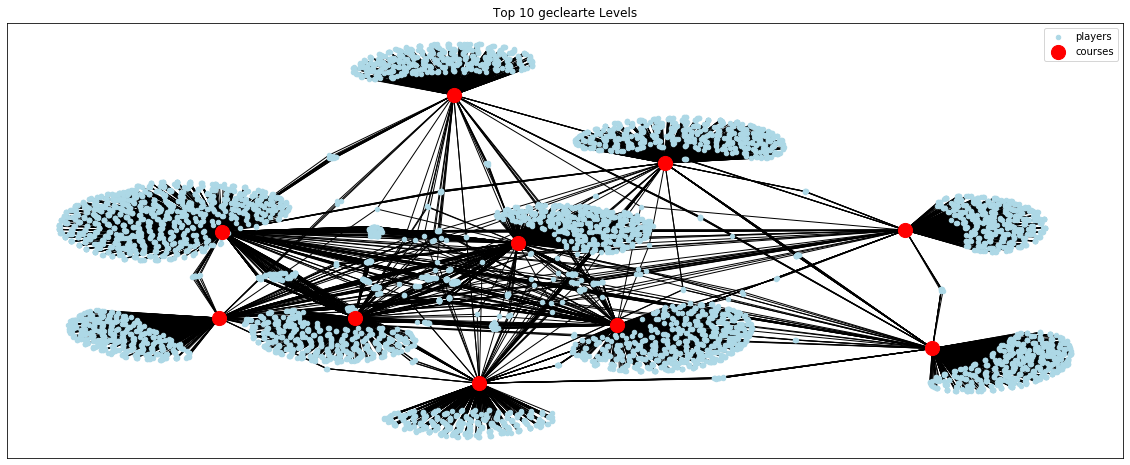

In [14]:
top_10_level_clears = edges_clears.groupby(by='target').count().reset_index().sort_values(by='source').iloc[-10:,:]['target']
top_10_level_edges = edges_clears[edges_clears['target'].isin(top_10_level_clears)]
G_top_10_level_clears = nx.from_pandas_edgelist(top_10_level_edges, create_using=nx.Graph())

plt.figure(figsize=(20,8))
#nx.draw_networkx(G_top_10_clears, with_labels=False, node_size=20)
pos = nx.drawing.layout.spring_layout(G_top_10_level_clears, seed = 42)
nx.draw_networkx_nodes(G_top_10_level_clears, pos, nodelist=top_10_level_edges['source'].unique(), node_size=20, node_color="lightblue", label='players')
nx.draw_networkx_nodes(G_top_10_level_clears, pos, nodelist=top_10_level_edges['target'].unique(), node_size=200, node_color="red", label='courses')
nx.draw_networkx_edges(G_top_10_level_clears, pos)
plt.title('Top 10 geclearte Levels')
plt.legend()
plt.show()

In [15]:
print(nx.info(G_top_10_level_clears))

Name: 
Type: Graph
Number of nodes: 6287
Number of edges: 7070
Average degree:   2.2491


Die meisten Spieler nur eines dieser Levels durchgespielt, was an den blauen Klumpen zu erkennen ist. Wahrscheinlich fürt die grosse Levelvielfalt zu dieser geringen Vernetzung der top 10 Levels unter den Spielern.<br><br>

Als nächstes schauen wir uns die gemeinsamen Spieler der Top 10 Levels an, um herauszufinden, wie die Levels bezüglich Spielerbasis zusammenhängen. Dies kann bewerkstelligt werden, in dem das vorherige Top 10 Level Netzwerk bezüglich clears von einem Two-Mode in ein One-Mode Netzwerk porjeziert wird, und die Anzahl gemeinsamen Verbindungen das Kantengewicht darstellt. Die Labels der 10 wichtigsten Levels werden nicht angezeigt, da das Anzeigen der ID keinen Mehrwert generiert.

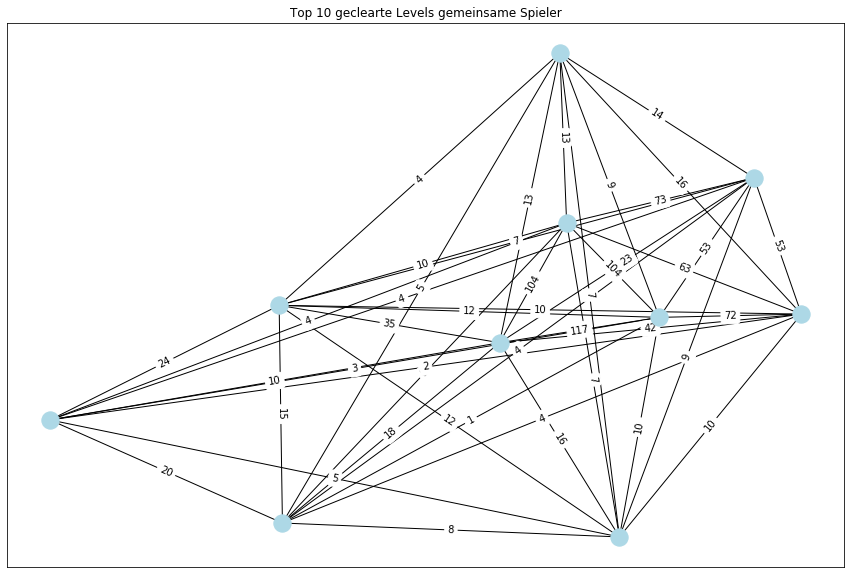

In [16]:
def draw_emphasizing_edge_weight(G, title=None, seed=42):
    plt.figure(figsize=(15,10))
    pos = nx.drawing.layout.spring_layout(G, seed=seed)
    
    nx.draw_networkx_nodes(G, pos, node_color="lightblue")
    nx.draw_networkx_edges(G, pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    plt.title(title)
    plt.show()
        
G_top_10_level_clears_first_group, G_top_10_level_clears_second_group = bipartite.sets(G_top_10_level_clears)
wp_G_top_10_level_clears = bipartite.weighted_projected_graph(G_top_10_level_clears, G_top_10_level_clears_second_group)
draw_emphasizing_edge_weight(wp_G_top_10_level_clears, title='Top 10 geclearte Levels gemeinsame Spieler', seed=39)

In [17]:
print(nx.info(wp_G_top_10_level_clears))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 44
Average degree:   8.8000


Der Graph zeigt gemeinsame Spielerbasen von keine gemeinsamen Spieler bis 117 gemeinsame Spieler. Ein kleiner Teil der Levels (Gewicht > 50) scheint stärker durch die Spieler verknüpf zu sein als der Rest.<br><br>

### Statistik Plays & Clears

Uns interessiert nun, ob es zwischen den Beziehungen Korrelationen gibt. Als erstes untersuchen wir den linearen Zusammenhang zwischen den Anzahl plays (angespielte Levels) und clears.

In [18]:
plays_count = plays.groupby(by='player').agg('count').rename(columns={'catch':'plays'})[['plays']].reset_index()
clears_count = clears.groupby(by='player').agg('count').rename(columns={'catch':'clears'})[['clears']].reset_index()
likes_count = likes.groupby(by='player').agg('count').rename(columns={'catch':'likes'})[['likes']].reset_index()

In [19]:
plays_clears = plays_count.merge(clears_count, on='player')
likes_clears = likes_count.merge(clears_count, on='player')

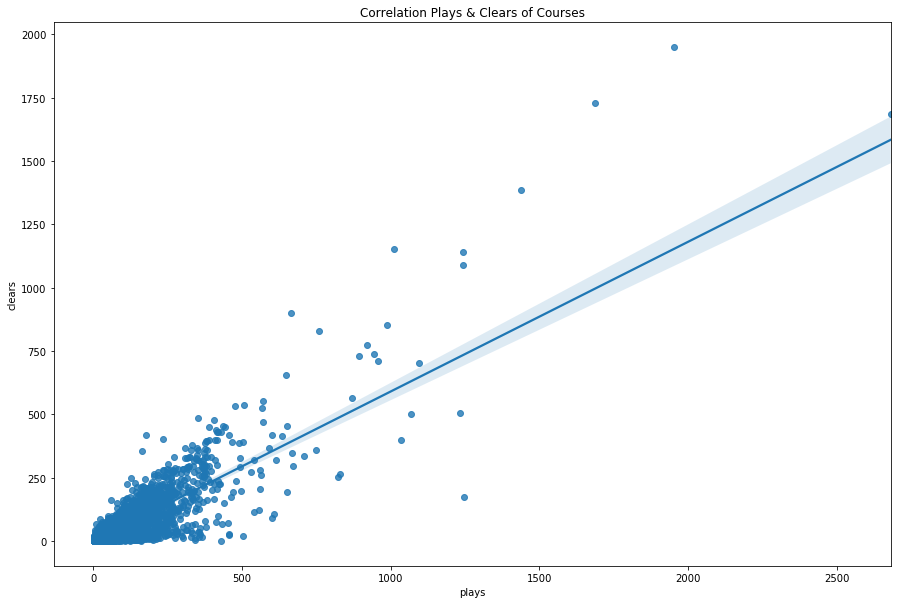

In [20]:
_ = plt.figure(figsize=(15,10))
_ = sns.regplot(x='plays', y='clears', data=plays_clears)
_ = plt.title('Correlation Plays & Clears of Courses')

In [21]:
plays_clears_pearson = plays_clears['plays'].corr(plays_clears['clears'], method='pearson')
plays_clears_pearson

0.8790071542209849

Der Pearson Korrelationskoeffizient von $\approx$ 0.88 zeigt, dass die Anzahl angespielten Levels (plays) sehr stark mit den Anzahl geschafften Levels (clears) linear zusammenhängen. Die starke Korrelation ist nicht überraschend aufgrund der Natur der Sache, da ein Clear nur stattfinden kann wenn ein Play stattgefunden hat. Es besteht also eine direkte Abhängigkeit zwischen Clears und Plays.<br><br>

Weniger offensichtlich ist es, ob ein Like einen Zusammenhang hat, ob man ein Level geschafft hat oder nicht unter einem Signifikanzniveau von 99% ($\alpha$ = 0.01). Da beide Variablen nominal skaliert sind, kommt der Chi$^2$ Test zur Anwendung.<br>
$H_0$: Es gibt KEINEN Unterschied bezüglich einem Like und ob man ein Level geschafft hat oder nicht<br>
$H_A$: Es gibt einen Unterschied bezüglich einem Like, ob man ein Level geschafft hat oder nicht

In [22]:
from scipy.stats import chi2_contingency

plays_likes = plays.merge(likes, on=['id','player'], how='left')
plays_likes['like'] = plays_likes['catch_y'].notna()
plays_likes = plays_likes[['id','player','like']]
plays_likes_clears = plays_likes.merge(clears, on=['id','player'], how='left')
plays_likes_clears['clear'] = plays_likes_clears['catch'].notna()
plays_likes_clears = plays_likes_clears[['id','player','like','clear']]

like_clear = plays_likes_clears[(plays_likes_clears['like'] == True) & (plays_likes_clears['clear'] == True)].shape[0]
likenot_clear = plays_likes_clears[(plays_likes_clears['like'] == False) & (plays_likes_clears['clear'] == True)].shape[0]
like_clearnot = plays_likes_clears[(plays_likes_clears['like'] == True) & (plays_likes_clears['clear'] == False)].shape[0]
likenot_clearnot = plays_likes_clears[(plays_likes_clears['like'] == False) & (plays_likes_clears['clear'] == False)].shape[0]

contingency_table = np.array([[like_clear,likenot_clear],[like_clearnot,likenot_clearnot]])
chi2, p, dof, ex = chi2_contingency(contingency_table)

Hier zu sehen ist die Kontingenztabelle. Hier lässt sich bereits erahnen, dass es eine Abhängigkeit gibt, da mehr Spieler ein Level Like gemacht haben, wenn sie ein Level geschafft haben und mehr Spieler kein Like gemacht haben, wenn sie das Level nicht geschafft haben.

In [23]:
mi_liked = pd.MultiIndex.from_arrays([['liked']*2, [True,False]])
mi_cleared = pd.MultiIndex.from_arrays([['cleared']*2, [True,False]])
print('Kontingenztabelle')
pd.DataFrame(data=contingency_table, columns=mi_liked, index=mi_cleared)

Kontingenztabelle


liked         
                True     False
cleared True   333180  1571850
        False  101732  1934616

Hier sind die erwarteten Häufigkeiten der Kontingenztabelle zu sehen, wenn es keine Abhängigkeit zwischen den Variablen geben würde.

In [24]:
print('Erwartete Häufigkeiten')
pd.DataFrame(data=ex, columns=mi_liked, index=mi_cleared)

Erwartete Häufigkeiten


liked              
                       True          False
cleared True   210210.846907  1.694819e+06
        False  224701.153093  1.811647e+06

Nun schauen wir uns den P-Wert des Chi$^2$ Tests an.

In [25]:
p

0.0

Da der p < $\alpha$, d.h. 0.0 < 0.01, müssen wir die $H_0$ ablehnen. Es gibt also einen Unterschied, bezüglich der Anzahl Likes, ob der Spieler/in ein Level geschafft hat. Das heisst, Personen, welche ein Level geschafft haben, Liken ein Level häufiger, als wenn sie es nicht geschafft haben.<br>

## Link Prediction

Nun versuchen wir, eine Link-Prediction auf dem Datensatz bezüglich welche Spieler welches Level als nächstes spielen wird. Wir haben hier die Situation, dass wir ein two-mode Netzwerk haben. Die im Skript besprochenen Algorithmen beziehen sich ausschliesslich auf one-mode Netzwerke. Natürlich könnten wir das two-mode Netzwerk in ein one-mode umwandeln. Dadurch würden wir jedoch lediglich die Spieler, oder die Levels miteinander verbinden. Unser Ziel ist jedoch, Spielern ein Level vorzuschlagen, welches sie noch nicht benutzt haben.

Ein einfacher Ansatz wäre es, einer Community diejenigen Levels vorzuschlagen, welche von Spielern dieser Community gespielt wurden, sie selbst jedoch nocht nicht gespielt haben. Dies ist jedoch ein sehr aufwendiger Prozess, welcher immer wieder neu evaluiert und berechnet werden muss. Deswegen haben wir uns für einen anderen Ansatz entschieden. 

Ein two-mode Netzwerk kann auch als Adjazenzmatrix interpretiert werden, bei dem die Reihen die Spieler und die Kolonen die Levels beinhaltet. Damit haben wir eine Player-Level Interaktionsmatrix. Predictions können in diesem Kontext auch als Recommendations iterpretiert werden. Eine relativ bekannte Technik für Recommendations auf einer Interaktionsmatrix ist die Singulärwertzerlegung (SVD) der Matrix, mit einer anschliessenden Rekonstruktion, wobei nur $k$ Singulärwerte für die Rekonstruktion verwendet werden. Ein Vorteil dieses Verfahrens ist, dass für neue Spieler mit einer sogenannten *folding-in* Technik (Sarwar et al., 2002) sehr einfach und kostengünstig (bezüglich Rechenkapazität) Recommendations, also Predictions gemacht werden können. Die Prediction machen wir auf den Level-ID's. Ein späteres Matching mit dem Levelnamen wäre problemlos möglich, ist jedoch für diese Aufgabe nicht nötig.

### Level & Spieler Reduktion

Ein Problem der SVD ist, dass wir theoretisch eine Interaktionsmatrix von mehr als 800'000 Spielern mit mehr als 100'000 Leveln hätten. Dies ist eine viel zu Rechenintensive zerlegung, weshalb wir die Levels und Spieler vorfiltern.

Zuerst reduzieren wir die Anzahl Levels, in dem wir die 8000 am meisten gespielten Levels nehmen. Es ist wichtig, zuerst die Levels vor den Spielern zu filtern, damit wie bei den Spielern auch garaniteren können, dass diese noch vorhandene Levels gespielt haben. Es macht ja keinen Sinn, Links predicten zu wollen bei Spielern, welche keine bekannte Connection zu einem Level haben. `top_plays_levels` beinhaltet die 8000 am meisten gespielten Levels und `plays_red` beinhaltet die Player-Level Interaktionen der Top 8000 Levels.

In [26]:
plays_level_count = plays.groupby(by='id').agg('count').rename(columns={'catch':'plays'})[['plays']].reset_index()
top_plays_levels = plays_level_count.sort_values(by='plays', ascending=False).iloc[:8000].reset_index(drop=True)
top_plays_levels

,id,plays
0,5AB9-0000-038F-A23E,1673
1,F44D-0000-035E-496C,1143
2,DE4D-0000-035D-3AE1,1089
3,A4E1-0000-038D-0EBC,1021
4,8F40-0000-0391-4B50,1014
...,...,...
7995,3204-0000-033C-74FA,74
7996,4DD9-0000-032F-5323,74
7997,47E5-0000-032B-92FD,74
7998,4C5A-0000-036A-902D,74


In [27]:
plays_red = plays[plays['id'].isin(top_plays_levels['id'])]
plays_red

,catch,id,player
570,2018-01-31 14:38:02.804,000E-0000-0331-2D8D,rui0987
663,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,0111hiy
664,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,akibo-0915
665,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,alexisp2005
666,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,aomitsu2180
...,...,...,...
3941296,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,yuji1333
3941297,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,yuuna2010
3941298,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,YvetteMack
3941299,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,ZGAMER18


Schliesslich müssen wir noch die Spieler Filtern, welche mit den verbleibenden 8000 Levels am Meisten Interaktionen hatten. `plays_player_count` beinhaltet diese 10000 Spieler und `plays_top_levels_players` repräsentiert die Level-Spieler Interaktionen der Top 8000 Levels und der Top 10000 Spieler bezüglich "Level gespielt".

In [28]:
plays_player_count = plays_red.groupby(by='player').agg('count').rename(columns={'catch':'plays'})[['plays']].reset_index()
top_plays_players = plays_player_count.sort_values(by='plays', ascending=False).iloc[:10000].reset_index(drop=True)
top_plays_players

,player,plays
0,Conducteur59220,746
1,Plusbellelavie5,746
2,Feuxdelamoule,599
3,cowboye123,576
4,indien1966,496
...,...,...
9995,Adam-Damian,10
9996,hiroto-yuuga,10
9997,Axepick06,10
9998,FarmerRobison,10


In [29]:
plays_top_levels = plays[plays['id'].isin(top_plays_levels['id'])]
plays_top_levels_players = plays_top_levels[plays_top_levels['player'].isin(top_plays_players['player'])].reset_index(drop=True)
plays_top_levels_players['play'] = 1
plays_top_levels_players

,catch,id,player,play
0,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,arti81,1
1,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,bulldog1979,1
2,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,CardcaptorGirl,1
3,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,Conducteur59220,1
4,2017-12-18 14:48:02.654,000E-0000-0331-2D8D,Doddsyctd,1
...,...,...,...,...
236059,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,TechOWeb,1
236060,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,TOOKOOL614,1
236061,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,YvetteMack,1
236062,2018-03-02 10:08:07.374,FFFC-0000-0346-165A,ZGAMER18,1


### SVD Model

Nun erstellen wir die Interaktionsmatrix, welche als `user_play_matrix` repräsentiert wird. `levelIdx_levelId` sieht eine Übersetzung des Matrixindexes der Levels zu den Level-Ids vor. Nun gilt es herauszufinden, welches $k$ wir verwenden wollen für die Rekonstruktion. SVD ist definiert als: $A = U\Sigma V^T$, wobei $\Sigma$ eine Diagonalmatrix mit den Singulärwerten rsp. den Wurzeln der Eigenwerte von $A^T A$ oder $A A^T$ sind. Wenn $A \in \mathbb{R}^{10000 \times 8000}$, dann kann $A$ mit $U \in \mathbb{R}^{10000 \times k}$, $\Sigma \in \mathbb{R}^{k \times k}$ und $V \in \mathbb{R}^{k \times 8000}$, approximiert werden, wobei $k$ die Anzahl Singulärwerte sind.

In [31]:
df_user_play_matrix = plays_top_levels_players.pivot(index='player', columns='id', values='play')
df_user_play_matrix = df_user_play_matrix.fillna(0)
levelIdx_levelId = {level_idx:level_id for level_idx, level_id in enumerate(df_user_play_matrix.columns)}
user_play_matrix = df_user_play_matrix.to_numpy()

Nun müssen wir $k$ definieren. Eigentlich ist dies ein Hyperparameter des SVD Models. Da wir aus Zeitgründen jedoch keine Evaluation mittels einer Zielmetrik vornehmen, versuchen wir, $k$ mittels der Visualisierung der Singulärwerte abzuschätzen. Optimalerweise haben wir eine elbogenförmige Form der Singulärwerte, wobei wir dann $k$ nahe an diesem Bogen wählen können.

In [32]:
U_eval, s_eval, V_eval = scipy.sparse.linalg.svds(csc_matrix(user_play_matrix), k=500)

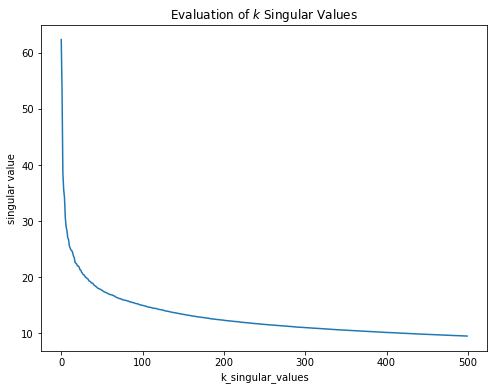

In [40]:
top_500_singular_values = np.sort(s_eval)[::-1]
_ = plt.figure(figsize=(8, 6))
_ = plt.plot(top_500_singular_values)
_ = plt.xlabel('k_singular_values')
_ = plt.ylabel('singular value')
_ = plt.title('Evaluation of $k$ Singular Values')

Die sträkste Beugung ist bei ca. 30-40 Singulärwerten zu beobachten. Wir wählen konservativ leicht mehr Singulärwerte, damit die Approximation ein bisschen besser wird.

### SVD Prediction

Nun erstellen wir das SVD Model mit 50 Singulärwerten, und rekonstruieren die Interaktonsmatrix anschliessend in `reconstruction`. Anschliessend müssen wir alle Werte, welche in der Orginalen Interaktionsmatrix `user_play_matrix` auf 1 gesetzt waren auf 0 setzen, damit nicht schon bisherig gespielte Levels als Prediction vorgeschlagen werden. Dies erreichen wir mit einer Matrix `user_play_matrix_remove_ones` , welche die gleiche Dimension hat wie `user_play_matrix` und überall aus 1 besteht, ausser da, wo bei `user_play_matrix` 1 war (da setzen wir die Werte auf 0). Anschliessend können wir die beiden Matrizen miteinander elementweise Multiplizieren, damit die bisherigen Levels auf 0 gesetzt werden, und damit nicht mehr in der Prediction vorkommen. Das Resultat wird in `user_play_predictions` gespeichert.

In [34]:
U, s, Vt = scipy.sparse.linalg.svds(csc_matrix(user_play_matrix), k=50)
reconstruction = (U @ np.diag(s)) @ Vt

In [35]:
upm_idx1 = np.where(user_play_matrix == 1) # indexes where play was 1 to set to 0
user_play_matrix_remove_ones = np.ones(user_play_matrix.shape) # matrix initialisation to elementwise multiply with ones except `upm_idx1` to remove previous plays
user_play_matrix_remove_ones[upm_idx1] = 0
user_play_predictions = reconstruction * user_play_matrix_remove_ones

Nun haben wir eine Approximation der Interaktonsmatrix, welche die wesentliche Struktur noch einigermassen beibehalten hat. Somit haben wir eine neue Adjazenzmatrix mit ein bisschen Noise und ohne die bisherigen Verbindungen. Es verbleibt nur noch, die Link Prediction zu machen, also, welcher Spieler welches Level als nächstes spielt. Dafür holen wir pro Spieler die Indizes der 10 grössten Werte (top 10 Prediction) heraus. Diese werden in `top_n_idx` gespeichert. Anschliessend kann mittels `levelIdx_levelId` vom Index auf das Level geschlossen werden.

In [36]:
top_n = 10
top_n_idx = np.argpartition(user_play_predictions, -top_n, axis=1)[:,-top_n:]

In [37]:
top_n_idx

array([[5794, 7768,  248, ..., 1589,  331, 5787],
       [7524, 3878,  544, ..., 1059, 7782, 3008],
       [3150, 2463,  128, ...,  248, 4145, 3725],
       ...,
       [3860, 7768, 1579, ..., 2730, 6237, 7493],
       [6310,  448, 4839, ..., 5083, 1261, 6800],
       [3028, 2201, 3572, ..., 1965, 1955, 4249]], dtype=int64)

In [38]:
levelIdx_levelId[top_n_idx[0,0]]

'BB01-0000-0361-084F'

Aus Zeitgründen haben wir auf eine Evaluation verzichtet. Wir denken trotzdem, dass dies ein wahrscheinlich guter weg ist, um eine Link-Prediction in einem two-mode Netzwerk vorzunehmen.

## Quellen

Sarwar, B., Karypis, G., Konstan, J., & Riedl, J. (2002). Incremental singular value decomposition algorithms for highly scalable recommender systems. Fifth international conference on computer and information science, 1(012002), 27–28.

